In [20]:
using JuMP
using Gurobi
using DataStructures: OrderedDict
using Iterators: subsets
using Polyhedra
using CDDLib

INFO: Precompiling module Polyhedra.
INFO: Precompiling module CDDLib.


In [3]:
function verify_form(model::Model)
    isempty(model.obj.aff.vars) &&
    isempty(model.sdpconstr) && 
    isempty(model.quadconstr) && 
    isempty(model.conicconstrDuals) &&
    all(c.lb == -Inf || c.ub == Inf for c in model.linconstr)
end

verify_form (generic function with 1 method)

In [95]:
function get_objective_matrix(model::Model, vars, params)
    @assert verify_form(model)
    H = zeros(Float64, (length(vars), length(vars)))
    for i in 1:length(model.obj.qcoeffs)
        v1 = model.obj.qvars1[i]
        v2 = model.obj.qvars2[i]
        c = model.obj.qcoeffs[i]
        @assert !haskey(params, v1)
        @assert !haskey(params, v2)
        H[vars[v1], vars[v2]] = c
    end
    H + H' - Diagonal(diag(H))
end

function get_linconstr_matrices(model, vars, params)
    @assert verify_form(model)
    G = zeros(Float64, (length(model.linconstr), length(vars)))
    W = zeros(Float64, length(model.linconstr))
    S = zeros(Float64, (length(model.linconstr), length(params)))
    
    for (i, constraint) in enumerate(model.linconstr)
        for (j, var) in enumerate(constraint.terms.vars)
            coeff = constraint.terms.coeffs[j]
            if constraint.lb == -Inf
                W[i] = constraint.ub
                if haskey(vars, var)
                    G[i, vars[var]] = coeff
                else
                    S[i, params[var]] = -coeff
                end
            else
                @assert constraint.ub == Inf
                W[i] = -constraint.lb
                if haskey(vars, var)
                    G[i, vars[var]] = -coeff
                else
                    S[i, params[var]] = coeff
                end
            end
        end
    end
    G, W, S
end

get_linconstr_matrices (generic function with 1 method)

In [106]:
model = Model(solver=GurobiSolver())
@variables model begin
    z[1:2]
end
vars = OrderedDict{Variable, Int}(zip(z, 1:2))

@variables model begin
    x[1:2] == 0
end
params = OrderedDict{Variable, Int}(zip(x, 1:2))


# Taking a model directly from Tondel et al. 2003, Example 1
dt = 0.05
A = [1 dt; 0 1]
b = [dt^2, dt]
H = [1.079 0.076; 0.076 1.073]
F = [1.109 1.036; 1.573 1.517]
G = [
    1 0;
    0 1;
    -1 0;
    0 -1;
    dt 0;
    dt dt;
    -dt 0;
    -dt -dt
]
W = [1; 1; 1; 1; 0.5; 0.5; 0.5; 0.5]
S = [
    1.0 1.4;
    0.9 1.3;
    -1.0 -1.4;
    -0.9 -1.3;
    0.1 -0.9;
    0.1 -0.9;
    -0.1 0.9;
    -0.1 0.9
]


@constraints model begin
    G * z .<= W + S * x
end

@objective model Min (z' * H * z)[1]

@assert verify_form(model)

model

Minimization problem with:
 * 8 linear constraints
 * 4 variables
Solver is Gurobi

In [107]:
get_linconstr_matrices(model, vars, params)

(
[1.0 0.0; 0.0 1.0; … ; -0.05 0.0; -0.05 -0.05],

[1.0,1.0,1.0,1.0,0.5,0.5,0.5,0.5],
[1.0 1.4; 0.9 1.3; … ; -0.1 0.9; -0.1 0.9])

In [108]:
get_objective_matrix(model, vars, params)

2×2 Array{Float64,2}:
 1.079  0.076
 0.076  1.073

In [109]:
result = solve(model)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 8 rows, 4 columns and 26 nonzeros
Model has 3 quadratic objective terms
Coefficient statistics:
  Matrix range     [5e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+00]
Presolve removed 8 rows and 2 columns
Presolve time: 0.00s
Presolved: 0 rows, 2 columns, 0 nonzeros
Presolved model has 3 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 0.000e+00
 Factor NZ  : 1.000e+00
 Factor Ops : 1.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.66911724e+05 -2.73977375e+05  1.04e+03 5.33e+02  1.00e+06     0s
   1   5.17272160e-04 -5.97906241e+03  2.03e-03 1.05e-03  1.50e+03     0s
   2   4.69978106e-04 -6.04532

:Optimal

In [110]:
getvalue.(z)

2-element Array{Float64,1}:
 -4.11449e-13
  6.99796e-12

In [111]:
function linearly_independent_subset(G, active_indices)
    num_constraints = min(length(active_indices), size(G, 2))
    for Ai in subsets(active_indices, num_constraints)
        GA = @view G[Ai,:]
        if rank(GA) == num_constraints
            return Ai
        end
    end
    error("No linearly indepdendent set of rows could be found")
end

linearly_independent_subset (generic function with 1 method)

In [113]:
function critical_region(model, vars, params, param_lb, param_ub)
    H = get_objective_matrix(model, vars, params)
    G, W, S = get_linconstr_matrices(model, vars, params)
    active_constraint_indices = [i for (i, constr) in enumerate(model.linconstr) if isapprox(getvalue(constr.terms), constr.ub) || isapprox(getvalue(constr.terms), constr.lb)]
    @show active_constraint_indices
    
    Ai = linearly_independent_subset(G, active_constraint_indices)
    GA = @view G[Ai,:]
    WA = @view W[Ai,:]
    SA = @view S[Ai,:]   
    @show H GA
    
    crmodel = Model()
    @variable crmodel x[1:length(params)]
    lambdaA = -inv(GA * inv(H) * GA') * (WA + SA * x)
    z = vec(-inv(H) * GA' * lambdaA)
    @constraint crmodel G * z .- S * x .- W .<= 0
    @constraint crmodel -lambdaA .<= 0
#     @constraint crmodel param_lb .<= x .<= param_ub
    crmodel
end

    

critical_region (generic function with 2 methods)

In [114]:
crmodel = critical_region(model, vars, params, -10*ones(5), 10*ones(5))

active_constraint_indices = Int64[]
H = [1.079 0.076; 0.076 1.073]
GA = 


Feasibility problem with:
 * 8 linear constraints
 * 2 variables
Solver is default solver

In [115]:
vr = SimpleVRepresentation(polyhedron(crmodel, CDDLibrary()))

V-representation
begin
 4 3 real
 1 1.5384615384615388 -0.3846153846153846
 1 0.19230769230769162 0.5769230769230768
 1 -1.538461538461538 0.3846153846153845
 1 -0.19230769230769235 -0.5769230769230769
end

In [116]:
vr.V

4×2 Array{Float64,2}:
  1.53846   -0.384615
  0.192308   0.576923
 -1.53846    0.384615
 -0.192308  -0.576923

In [117]:
using Plots


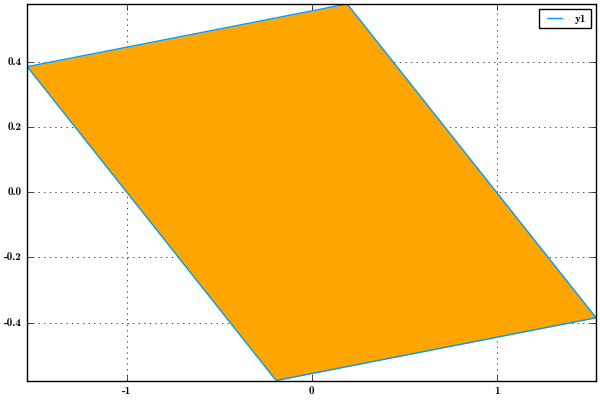

In [122]:
plot(vr.V[[1:end; 1],1], vr.V[[1:end; 1],2], fill=(0,:orange))